# Workers productivity

Contenido:
- Analisis de datos de la productividad de trabajadores.
- Modelo predictivo de la productividad de los trabajadores.

## **NOTA** : eliminar datos que sobresalen algunas metricas, como mas de 1, etc

Queremos predecir o queremos clasficar si es buena o mala la real vs la objetivo

Importamos librerias necesarias

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.metrics import accuracy_score,r2_score, mean_squared_error, mean_absolute_error, mean_squared_log_error

Leemos nuestros datos

In [2]:
df = pd.read_csv('garments_worker_productivity.csv')

Atributos del dataset:
1. **date**: Fecha en MM-DD-AAAA
3. **quarter**: Una parte del mes. Un mes se divide en cuatro trimestres
4. **department**: Departamento asociado
2. **day**: Día de la semana
5. **team**: Número de equipo asociado a la instancia
8. **targeted_productivity**: Objetivo de productividad fijado por la autoridad para cada equipo para cada día
9. **smv**: Valor estándar del minuto, es el tiempo asignado a una tarea 
10. **wip**: Trabajos en curso. Incluye el número de artículos sin terminar para los productos 
11. **over_time**: Representa la cantidad de tiempo extra de cada equipo en minutos
12. **incentive**: Representa el importe del incentivo financiero (en BDT) que permite o motiva una determinada acción
13. **idle_time**: La cantidad de tiempo en que la producción se interrumpió debido a varias razones 
14. **idle_men**: El número de trabajadores que estuvieron inactivos debido a la interrupción de la producción
7. **no_of_style_change**: Número de cambios en el estilo de un determinado producto
6. **no_of_workers**: Número de trabajadores en cada equipo
15. **actual_productivity**: Es el porcentaje real de productividad que han aportado los trabajadores. Va de 0 a 1.

# Exploratory Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   quarter                1197 non-null   object 
 2   department             1197 non-null   object 
 3   day                    1197 non-null   object 
 4   team                   1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 7   wip                    691 non-null    float64
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
 13  no_of_workers          1197 non-null   float64
 14  actual_productivity    1197 non-null   float64
dtypes: f

Veamos cuantos valores nulos tenemos

In [4]:
df.isnull().sum()

date                       0
quarter                    0
department                 0
day                        0
team                       0
targeted_productivity      0
smv                        0
wip                      506
over_time                  0
incentive                  0
idle_time                  0
idle_men                   0
no_of_style_change         0
no_of_workers              0
actual_productivity        0
dtype: int64

Veamos los tipos de departamentos

In [5]:
df['department'].value_counts()

sweing        691
finishing     257
finishing     249
Name: department, dtype: int64

Podemos ver que el mismo departamento por un error en la escritura lo toma como uno diferente

La descripcion nos dice que la productividad va de 0 - 1, veamos si hay valores que se salen de ese rango.

In [6]:
column = df['actual_productivity']
count = column[column > 1].count()
count 

37

Ahora, arreglemos un poco nuestro dataset ya con el analisis que hicimos anteriormente. 

Eliminemos aquellos renglones en donde la productividad fue mayor a 1

In [7]:
df = df.drop(df[df['actual_productivity'] > 1].index)
df

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,01/01/15,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,01/01/15,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,01/01/15,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,01/01/15,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,01/01/15,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,03/11/15,Quarter2,finishing,Wednesday,10,0.75,2.90,NaN,960,0,0.0,0,0,8.0,0.628333
1193,03/11/15,Quarter2,finishing,Wednesday,8,0.70,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1194,03/11/15,Quarter2,finishing,Wednesday,7,0.65,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1195,03/11/15,Quarter2,finishing,Wednesday,9,0.75,2.90,NaN,1800,0,0.0,0,0,15.0,0.505889


Ahora fusionemos los dos departamentos de "finishing".

In [8]:
df['department'] = df['department'].apply(lambda x: 'finishing' if x.replace(" ","") == 'finishing' else 'sewing' )

Podemos ver que ahora ya tenemos los departamentos correctos

<AxesSubplot: ylabel='department'>

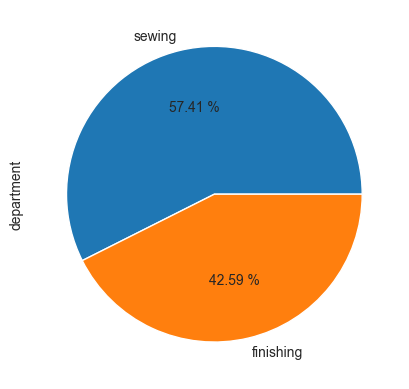

In [9]:
df.department.value_counts().plot.pie(autopct='%.2f %%')

### Saquemos algunas graficas

Comparemos la productividad real y la productividad objetivo para ver el rendimiento de los empleados.

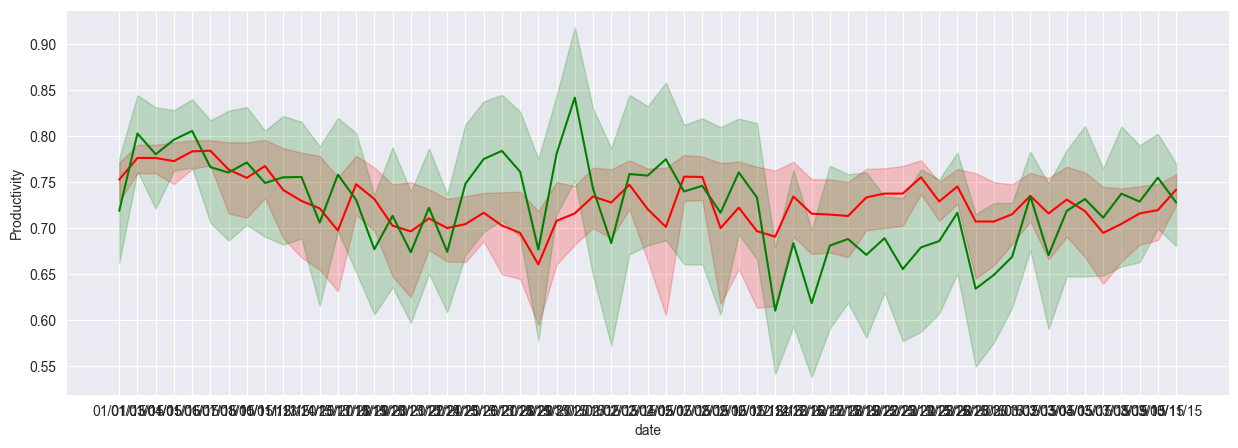

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (15,5))
ax=sns.lineplot(y='targeted_productivity',x='date' ,color = "red", data =df,legend='brief')
ax=sns.lineplot(y= 'actual_productivity',x='date',data=df, color="green", legend = 'brief')
ax.set(ylabel = 'Productivity')
plt.show()

Ahora analicemos si el día concreto de la semana o el equipo o el departamento tiene algún efecto significativo en la productividad.

Productividad en Thursday :  0.7129915972435232
Productividad en Saturday :  0.7448301823956044
Productividad en Sunday :  0.7176795450459182
Productividad en Monday :  0.7294553565179488
Productividad en Tuesday :  0.7332077270257732
Productividad en Wednesday :  0.7191576944549999


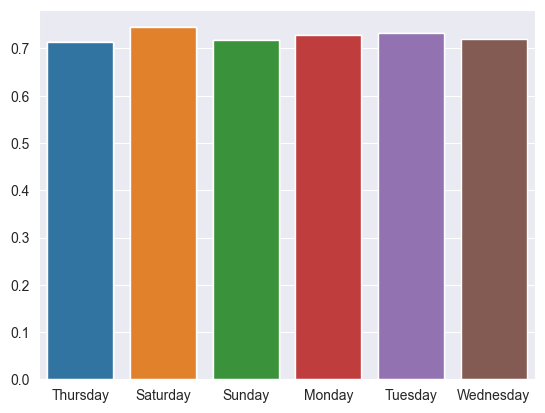

In [11]:
l = []
l1=[]
column_name = "day"
for i in list(df[column_name].unique()):
    print( f"Productividad en {i} : ",df[df[column_name] == i]["actual_productivity"].mean())
    l.append(df[df[column_name] == i]["actual_productivity"].mean())
    l1.append(i)
    dictionary = {"data":l,"keys":l1}
    sns.barplot( x = "keys" , y = "data", data = dictionary)
# plt.savefig('days.png')

Como podemos ver arriba, la productividad no depende del equipo, la categoría, el trimestre o el día.

Vamos a trazar la matriz de correlación para ver la cantidad de correlación -

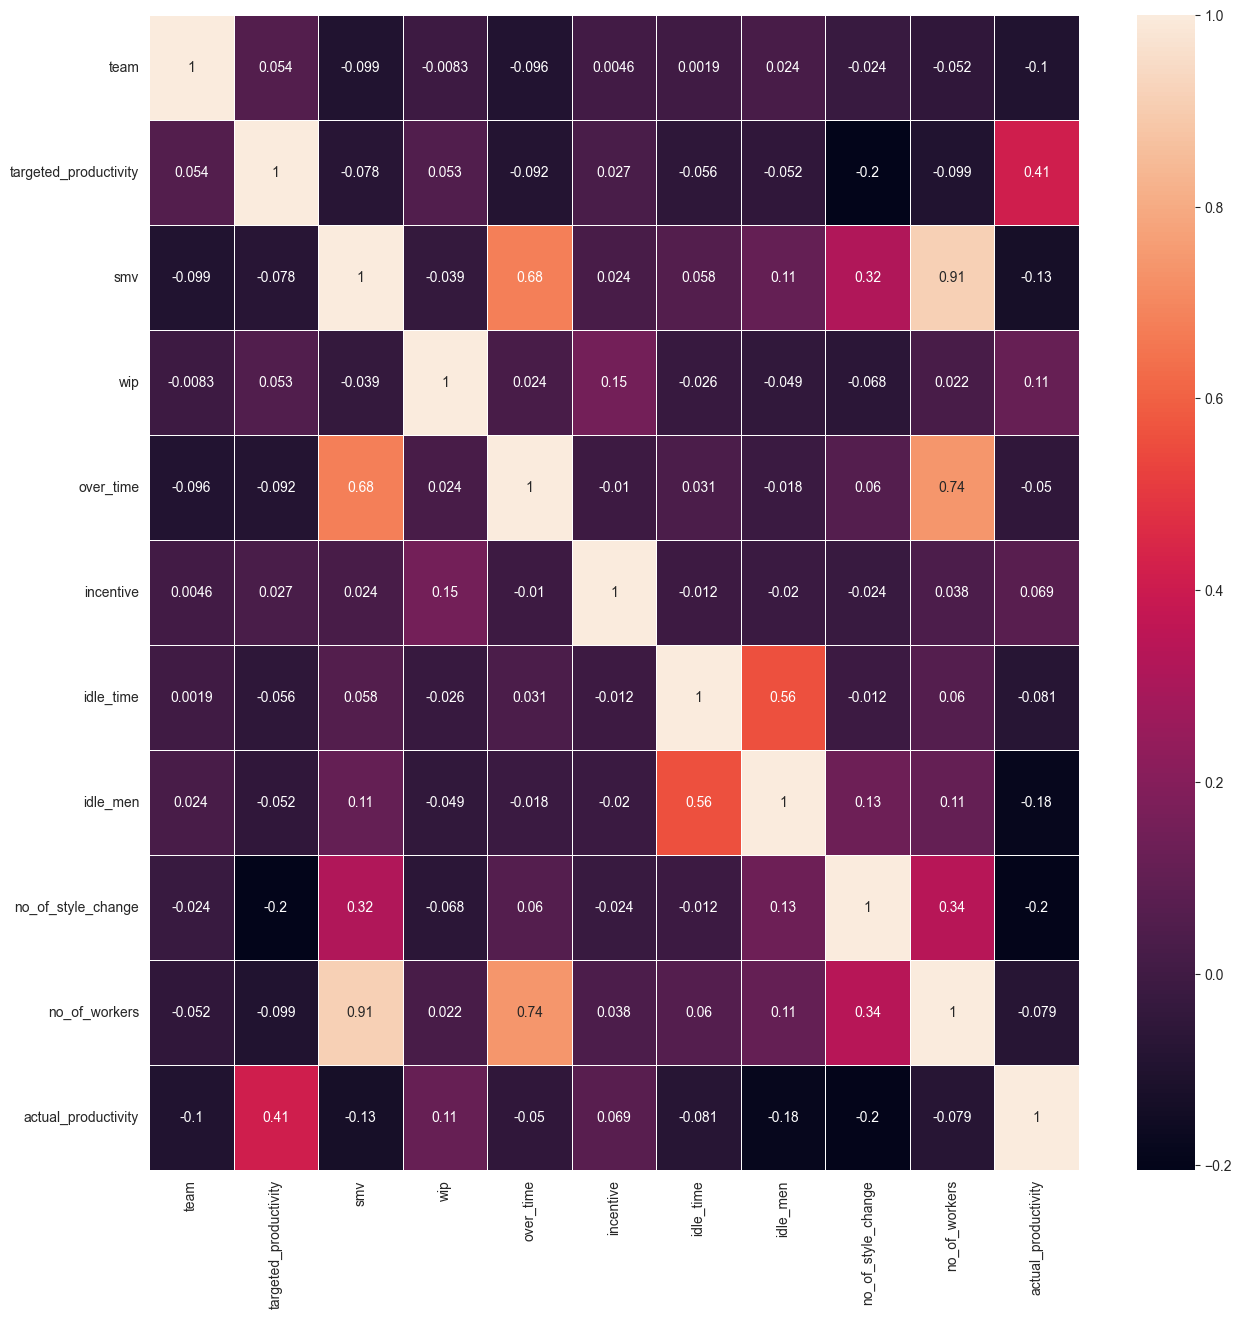

In [12]:
corrMatrix = df.corr()
fig, ax = plt.subplots(figsize=(15,15)) # Sample figsize in inches
sns.heatmap(corrMatrix, annot=True, linewidths=.5, ax=ax)
plt.show()

A partir de estos datos, es evidente que la productividad depende principalmente del objetivo de productividad, ya que el hecho de tener un objetivo motivará e impulsará a los empleados.

## Preparemos los datos finales

Hagamos una limpieza y un preprocesamiento de los datos antes de pasar a la predicción

In [13]:
df['date'] = pd.to_datetime(df['date'])

In [14]:
df.date

0      2015-01-01
1      2015-01-01
2      2015-01-01
3      2015-01-01
4      2015-01-01
          ...    
1192   2015-03-11
1193   2015-03-11
1194   2015-03-11
1195   2015-03-11
1196   2015-03-11
Name: date, Length: 1160, dtype: datetime64[ns]

Así que los datos que tenemos son de 3 meses. 
Optamos por dejar el dia ya que como son pocos meses es suficiente en lugar de la fecha completa.

In [15]:
df['Dia']=df['date'].dt.day
df.drop(['date'],axis=1, inplace=True)

Optamos por llenar los wip faltantes por la media de la misma

In [16]:
df['wip'].fillna(int(df['wip'].mean()), inplace=True)

In [17]:
df.isnull().sum()

quarter                  0
department               0
day                      0
team                     0
targeted_productivity    0
smv                      0
wip                      0
over_time                0
incentive                0
idle_time                0
idle_men                 0
no_of_style_change       0
no_of_workers            0
actual_productivity      0
Dia                      0
dtype: int64

Ahora podemos ver que no tenemos datos faltantes

### Encode

En los datos, puedes ver algunas columnas no numéricas. Así que vamos a codificarlas, ya que la mayoría de los algoritmos de aprendizaje automático sólo funcionan con datos numéricos.

Let’s encode the data with MultiColumnLabelEncoder

In [18]:
!pip install MultiColumnLabelEncoder

In [19]:
import MultiColumnLabelEncoder

In [20]:
Mcle = MultiColumnLabelEncoder.MultiColumnLabelEncoder()
df = Mcle.fit_transform(df)

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#scaler = StandardScaler()
scaler = MinMaxScaler()


# standarizing data
scaled_data = scaler.fit_transform(df)

# creating dataframe with standarized features
scaled_df = pd.DataFrame(scaled_data, index=df.index, columns=df.columns)


In [22]:
scaled_df

,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,Dia
0,0.00,0.0,0.0,0.636364,1.000000,0.450252,0.047631,0.273148,0.027222,0.0,0.0,0.0,0.655172,0.922654,0.000000
1,0.00,1.0,0.0,0.000000,0.931507,0.020132,0.049838,0.037037,0.000000,0.0,0.0,0.0,0.068966,0.851890,0.000000
2,0.00,0.0,0.0,0.909091,1.000000,0.164731,0.041575,0.141204,0.013889,0.0,0.0,0.0,0.327586,0.739753,0.000000
3,0.00,0.0,0.0,1.000000,1.000000,0.164731,0.041575,0.141204,0.013889,0.0,0.0,0.0,0.327586,0.739753,0.000000
4,0.00,0.0,0.0,0.454545,1.000000,0.445219,0.050314,0.074074,0.013889,0.0,0.0,0.0,0.620690,0.739507,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,0.25,1.0,1.0,0.818182,0.931507,0.000000,0.049838,0.037037,0.000000,0.0,0.0,0.0,0.068966,0.514985,0.333333
1193,0.25,1.0,1.0,0.636364,0.863014,0.019357,0.049838,0.037037,0.000000,0.0,0.0,0.0,0.068966,0.511451,0.333333
1194,0.25,1.0,1.0,0.545455,0.794521,0.019357,0.049838,0.037037,0.000000,0.0,0.0,0.0,0.068966,0.511451,0.333333
1195,0.25,1.0,1.0,0.727273,0.931507,0.000000,0.049838,0.069444,0.000000,0.0,0.0,0.0,0.149425,0.355196,0.333333


In [23]:
# x = df.drop(['actual_productivity'],axis=1)
# y = df['actual_productivity']

x = scaled_df.drop(['actual_productivity'],axis=1)
y = scaled_df['actual_productivity']

## Prediciendo la productividad

Antes de tratar de predecir, vamos a preparar los datos de entrenamiento y de prueba

In [24]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y,train_size=0.8,random_state=0)

Los algoritmos que implementaremos para ver cual se adapta mejor a los datos son los siguientes:

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor

Funcion para obtener algunas metricas de los algoritmos con nuestros datos.

In [26]:
def impresionResultados(y_test, pred6):
    print("test_MSE:",mean_squared_error(y_test, pred6))
    print("test_MAE:",mean_absolute_error(y_test, pred6))
    print("R2_score:{}".format(r2_score(y_test, pred6)))

- LinearRegression

In [27]:
model_lr=LinearRegression()

model_lr.fit(x_train,y_train)
pred_test=model_lr.predict(x_test)
impresionResultados(y_test, pred_test)

test_MSE: 0.034845590062558086
test_MAE: 0.13654482265286297
R2_score:0.3016161363986355


- Random Forest Regressor

In [28]:
model_rfe = RandomForestRegressor(n_estimators=200,max_depth=5)

model_rfe.fit(x_train, y_train)
pred = model_rfe.predict(x_test)
impresionResultados(y_test, pred)

test_MSE: 0.0243731017066131
test_MAE: 0.10647691506054721
R2_score:0.5115083169131485


- XGBoost

In [29]:
model_xgb = xgb.XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.1)

model_xgb.fit(x_train, y_train)
pred3=model_xgb.predict(x_test)
impresionResultados(y_test, pred3)

test_MSE: 0.02177668153701455
test_MAE: 0.09707760000546288
R2_score:0.5635464068499623


- SVR

In [30]:
model_svr = SVR(kernel='rbf', C=10, epsilon=0.00001) # set kernel and hyperparameters

svr = model_svr.fit(x_train, y_train)
pred4 = model_svr.predict(x_test)
impresionResultados(y_test, pred4)

test_MSE: 0.028807372705514648
test_MAE: 0.1039261764302843
R2_score:0.42263556983357153


- Lasso

In [31]:
las_reg = Lasso()

las_reg.fit(x_train, y_train)
pred5 = las_reg.predict(x_test)
impresionResultados(y_test, pred5)

test_MSE: 0.05020900114611554
test_MAE: 0.17327119937344132
R2_score:-0.00630111715821835


- Ridge

In [32]:
# rid_reg = Ridge()

# rid_reg.fit(x_train, y_train)
# pred6 = rid_reg.predict(x_test)
# impresionResultados(y_test, pred6)

- Decision Tree Regressor

In [33]:
dt_regressor = DecisionTreeRegressor(random_state = 0)

dt_regressor.fit(x_train,y_train)
pred7 = dt_regressor.predict(x_test)
impresionResultados(y_test, pred7)


test_MSE: 0.035545760691109776
test_MAE: 0.11215735078846242
R2_score:0.28758314491046577
